#IMPORT

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [2]:

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary



[INFO] Couldn't find torchinfo... installing it.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# DATA LOADING

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# preparing transforms and dataloader for images

In [6]:

#Hyper parameter
LEARNING_RATE=10**(-4)
BATCH_SIZE = 100 
IMG_SIZE = 32
PATCH_SIZE=4
IN_CHANNELS=3
EMBEDDING_DIMENTION=PATCH_SIZE*PATCH_SIZE*IN_CHANNELS*5
NUM_HEADS=12
NUM_ATTENTION_LAYERS=4
DROPOUT_P=0.1
MLP_SIZE=1024
NUM_LABELS=10


In [7]:



manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")


#imgdata contains transformed images
train_dataset = CIFAR10(root='imgdata/', download=True, transform=manual_transforms)
test_dataset = CIFAR10(root='imgdata/', train=False, transform=manual_transforms)


train_dataloader = DataLoader(
      train_dataset,
      batch_size=BATCH_SIZE,
      shuffle=False,
      pin_memory=True,
  )
test_dataloader = DataLoader(
      test_dataset,
      batch_size=BATCH_SIZE,
      shuffle=False,
      pin_memory=True,
  )

train_dataloader, test_dataloader

Manually created transforms: Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting imgdata/cifar-10-python.tar.gz to imgdata/


(<torch.utils.data.dataloader.DataLoader at 0x7f70fcefeb50>,
 <torch.utils.data.dataloader.DataLoader at 0x7f70fcefeac0>)

torch.Size([100, 3, 32, 32]) torch.Size([100])


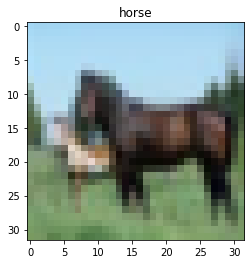

In [8]:
# Get a batch of images


image_batch, label_batch = next(iter(train_dataloader))
print(image_batch.shape,label_batch.shape)
# Get a single image from the batch
image, label = image_batch[12], label_batch[12]
plt.imshow(image.permute(1,2,0))
plt.title(train_dataset.classes[label])
plt.show()

# Patch embedding

In [9]:
class Patch_embedding(nn.Module):
    
    
    def __init__(self,
                 in_channels=IN_CHANNELS,
                 patch_size=PATCH_SIZE,
                 embedding_dim=EMBEDDING_DIMENTION
                ):
        
        super().__init__()
        self.patcher=nn.Conv2d(in_channels=in_channels,
                               out_channels=embedding_dim,
                               kernel_size=patch_size,
                               stride=patch_size,
                               padding=0
                              )
        
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
    def forward(self,x):
        image_resolution = x.shape[-1]
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        return x_flattened.permute(0, 2, 1)
        


In [10]:



patchify=Patch_embedding(in_channels=IN_CHANNELS,
                 patch_size=PATCH_SIZE,
                 embedding_dim=EMBEDDING_DIMENTION)



print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) 
print(f"Output patch embedding shape: {patch_embedded_image.shape}")



Input image shape: torch.Size([1, 3, 32, 32])
Output patch embedding shape: torch.Size([1, 64, 240])


In [11]:
summary(Patch_embedding())

Layer (type:depth-idx)                   Param #
Patch_embedding                          --
├─Conv2d: 1-1                            11,760
├─Flatten: 1-2                           --
Total params: 11,760
Trainable params: 11,760
Non-trainable params: 0

## including class token

In [12]:
class_token= nn.Parameter(torch.ones((1,1,EMBEDDING_DIMENTION)),requires_grad=True) #1 can be replaced with BATCH_SIZE
class_token.shape

torch.Size([1, 1, 240])

In [13]:
final_embedding=torch.cat((class_token,patch_embedded_image),dim=1)
final_embedding.shape

torch.Size([1, 65, 240])

# MSA LAYER

In [14]:

class MultiheadSelfAttentionBlock(nn.Module):
    
    def __init__(self,
                 embedding_dim =EMBEDDING_DIMENTION, 
                 num_heads=NUM_HEADS, 
                 attn_dropout=0):
        super().__init__()
        
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) 
        
    
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x, 
                                             value=x, 
                                             need_weights=False)
        return attn_output

In [15]:
Multihead=MultiheadSelfAttentionBlock()
print(final_embedding.shape)
after_msa_out=Multihead(final_embedding)
print(after_msa_out.shape)


torch.Size([1, 65, 240])
torch.Size([1, 65, 240])


# MLP layer in encoder

In [16]:

class MLPBlock(nn.Module):
    
    def __init__(self,
                 embedding_dim=EMBEDDING_DIMENTION, 
                 mlp_size = MLP_SIZE, 
                 dropout = DROPOUT_P): 
        super().__init__()
        
      
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
       
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), 
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, 
                      out_features=embedding_dim), 
            nn.Dropout(p=dropout) 
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [17]:
MLP=MLPBlock()
print(after_msa_out.shape)
after_mlp_out=MLP(after_msa_out)
print(after_mlp_out.shape)


torch.Size([1, 65, 240])
torch.Size([1, 65, 240])


# ENCODER BLOCK

In [18]:
class EncoderBlock(nn.Module):
   
    def __init__(self,
                 embedding_dim=EMBEDDING_DIMENTION, 
                 num_heads=NUM_HEADS, 
                 mlp_size=MLP_SIZE, 
                 mlp_dropout=DROPOUT_P, 
                 attn_dropout=0): 
        super().__init__()

        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
 
    def forward(self, x):
        
        
        x =  self.msa_block(x) + x 
        
        
        x = self.mlp_block(x) + x 
        
        return x

# ViT 

In [19]:

class ViT(nn.Module):
    
    def __init__(self,
                 img_size=IMG_SIZE, 
                 in_channels=IN_CHANNELS, 
                 patch_size=PATCH_SIZE, 
                 num_transformer_layers=NUM_ATTENTION_LAYERS, 
                 embedding_dim=EMBEDDING_DIMENTION, 
                 mlp_size=MLP_SIZE, 
                 num_heads=NUM_HEADS, 
                 attn_dropout=0, 
                 mlp_dropout=DROPOUT_P, 
                 embedding_dropout=DROPOUT_P, # Dropout for patch and position embeddings
                 num_classes=NUM_LABELS): 
        
        super().__init__() 
        
        
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
       
        self.patch_embedding = Patch_embedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        
        self.transformer_encoder = nn.Sequential(*[EncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
        print(f"PATCH_SIZE: {PATCH_SIZE} ")
    
    def forward(self, x):
        
        batch_size = BATCH_SIZE
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) 
        
        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0]) 

        return x       

In [20]:
from tqdm import tqdm

def train(model,
          train_dataloader,
          test_dataloader,
          max_epochs,
          device,
         ):
    
    
    optimiser=torch.optim.Adam(params=model.parameters(), 
                             lr=LEARNING_RATE)
#                              betas=(0.9, 0.999), 
#                              weight_decay=0.3) 
    loss_fn=nn.CrossEntropyLoss()
    
    
    model.to(device)
    
    loss_curve=[]
    train_acc_curve=[]
    test_acc_curve=[]
    
    for epoch in tqdm(range(max_epochs)):
        model.train()
        train_loss=0
        train_accuracy=0
        test_acc=0
        
        for batch_id,(X,y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred=model(X)
            #print(y_pred.shape,y.shape,y_pred,y)
            loss=loss_fn(y_pred,y)
            
            train_loss+=loss.item()
            
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            
            y_pred=torch.argmax(y_pred,dim=1)
            #print(y_pred.shape)
            batch_correct=((y_pred==y).sum().item())/BATCH_SIZE
            train_accuracy+=batch_correct
           # print(loss.item(),batch_correct)
        


        for batch_id,(X,y) in enumerate(test_dataloader):
                  
          X, y = X.to(device), y.to(device)
          y_pred=model(X)
          
          
          y_pred=torch.argmax(y_pred,dim=1)
          
          batch_correct=((y_pred==y).sum().item())/BATCH_SIZE
          test_acc+=batch_correct
          
            
            
        loss_curve.append(train_loss/len(train_dataloader))
        train_acc_curve.append(train_accuracy/len(train_dataloader))
        test_acc_curve.append(test_acc/len(test_dataloader))
        
        print(f"epoch:{epoch+1} train_loss:{loss_curve[-1]} train_acc:{train_acc_curve[-1]} test_acc:{test_acc_curve[-1]}")
             
    return loss_curve,train_acc_curve,test_acc_curve
        
            
        

In [21]:
summary(ViT())

PATCH_SIZE: 4 


Layer (type:depth-idx)                                            Param #
ViT                                                               15,840
├─Dropout: 1-1                                                    --
├─Patch_embedding: 1-2                                            --
│    └─Conv2d: 2-1                                                11,760
│    └─Flatten: 2-2                                               --
├─Sequential: 1-3                                                 --
│    └─EncoderBlock: 2-3                                          --
│    │    └─MultiheadSelfAttentionBlock: 3-1                      231,840
│    │    └─MLPBlock: 3-2                                         493,264
│    └─EncoderBlock: 2-4                                          --
│    │    └─MultiheadSelfAttentionBlock: 3-3                      231,840
│    │    └─MLPBlock: 3-4                                         493,264
│    └─EncoderBlock: 2-5                                          --
│

In [22]:
vit=ViT()


PATCH_SIZE: 4 


In [23]:
loss_curve,train_acc_curve,test_acc_curve=train(model=vit,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      device=device,
      max_epochs=10,
      )

 10%|█         | 1/10 [00:51<07:40, 51.18s/it]

epoch:1 train_loss:2.0090476934909822 train_acc:0.25514 test_acc:0.35669999999999985


 20%|██        | 2/10 [01:32<06:02, 45.36s/it]

epoch:2 train_loss:1.724073401927948 train_acc:0.37933999999999973 test_acc:0.4113000000000001


 30%|███       | 3/10 [02:13<05:05, 43.59s/it]

epoch:3 train_loss:1.5907057993412017 train_acc:0.42923999999999973 test_acc:0.4394000000000001


 40%|████      | 4/10 [02:54<04:15, 42.57s/it]

epoch:4 train_loss:1.5138507952690126 train_acc:0.45643999999999907 test_acc:0.46070000000000005


 50%|█████     | 5/10 [03:35<03:29, 41.96s/it]

epoch:5 train_loss:1.4539120209217071 train_acc:0.4784799999999997 test_acc:0.4754


 60%|██████    | 6/10 [04:17<02:46, 41.71s/it]

epoch:6 train_loss:1.4087342052459717 train_acc:0.49598000000000014 test_acc:0.49119999999999997


 70%|███████   | 7/10 [04:57<02:04, 41.41s/it]

epoch:7 train_loss:1.365682994365692 train_acc:0.5100800000000003 test_acc:0.5044999999999997


 80%|████████  | 8/10 [05:39<01:22, 41.34s/it]

epoch:8 train_loss:1.3280155415534973 train_acc:0.5232400000000005 test_acc:0.5121


 90%|█████████ | 9/10 [06:19<00:41, 41.22s/it]

epoch:9 train_loss:1.2890750863552094 train_acc:0.5386599999999999 test_acc:0.5241999999999997


100%|██████████| 10/10 [07:00<00:00, 42.08s/it]

epoch:10 train_loss:1.2574995181560515 train_acc:0.5479800000000009 test_acc:0.5322999999999999


In [24]:
#loss_curve,train_acc_curve,test_acc_curve

[]

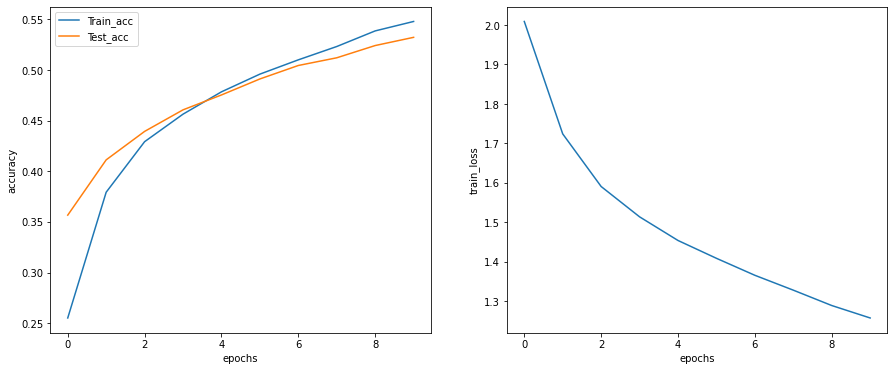

In [25]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(train_acc_curve,label="Train_acc")
plt.plot(test_acc_curve,label="Test_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss_curve)
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.plot()

#EXPERIMENT - ATTENTION HEADS.(EXPERIMENT 2)

In [27]:
DIFF_NUM_HEADS=[4,6,8,10,12,16]

num_head_map={}

In [28]:
for NUM_HEADS in DIFF_NUM_HEADS:
  vit=ViT()
  loss_curve,train_acc_curve,test_acc_curve=train(model=vit,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      device=device,
      max_epochs=5,
      )
  num_head_map[NUM_HEADS]=[loss_curve[-1],train_acc_curve[-1],test_acc_curve[-1]]


PATCH_SIZE: 4 


 20%|██        | 1/5 [00:40<02:41, 40.37s/it]

epoch:1 train_loss:2.0186403269767763 train_acc:0.24917999999999998 test_acc:0.3501999999999999


 40%|████      | 2/5 [01:21<02:02, 40.98s/it]

epoch:2 train_loss:1.7398650670051574 train_acc:0.37351999999999974 test_acc:0.41040000000000004


 60%|██████    | 3/5 [02:02<01:21, 40.90s/it]

epoch:3 train_loss:1.6229131150245666 train_acc:0.4197599999999996 test_acc:0.44049999999999984


 80%|████████  | 4/5 [02:42<00:40, 40.68s/it]

epoch:4 train_loss:1.540806301355362 train_acc:0.4474999999999994 test_acc:0.4559000000000001


100%|██████████| 5/5 [03:23<00:00, 40.65s/it]


epoch:5 train_loss:1.4817024948596955 train_acc:0.4704399999999996 test_acc:0.4707999999999999
PATCH_SIZE: 4 


 20%|██        | 1/5 [00:40<02:43, 40.77s/it]

epoch:1 train_loss:1.9962834203243256 train_acc:0.2619199999999998 test_acc:0.36140000000000005


 40%|████      | 2/5 [01:21<02:02, 40.72s/it]

epoch:2 train_loss:1.7282990458011627 train_acc:0.3800999999999998 test_acc:0.41200000000000003


 60%|██████    | 3/5 [02:01<01:21, 40.51s/it]

epoch:3 train_loss:1.6028489065170288 train_acc:0.42553999999999964 test_acc:0.4471999999999998


 80%|████████  | 4/5 [02:42<00:40, 40.66s/it]

epoch:4 train_loss:1.5195528671741485 train_acc:0.45533999999999936 test_acc:0.46749999999999986


100%|██████████| 5/5 [03:22<00:00, 40.60s/it]


epoch:5 train_loss:1.4610924649238586 train_acc:0.4776399999999999 test_acc:0.4762000000000002
PATCH_SIZE: 4 


 20%|██        | 1/5 [00:40<02:41, 40.32s/it]

epoch:1 train_loss:1.998773905992508 train_acc:0.2608400000000001 test_acc:0.35529999999999995


 40%|████      | 2/5 [01:21<02:01, 40.61s/it]

epoch:2 train_loss:1.7299843714237213 train_acc:0.37649999999999956 test_acc:0.42080000000000006


 60%|██████    | 3/5 [02:01<01:20, 40.38s/it]

epoch:3 train_loss:1.591568423271179 train_acc:0.42815999999999954 test_acc:0.4476999999999998


 80%|████████  | 4/5 [02:41<00:40, 40.41s/it]

epoch:4 train_loss:1.5104974815845489 train_acc:0.4581199999999996 test_acc:0.4671000000000001


100%|██████████| 5/5 [03:22<00:00, 40.49s/it]


epoch:5 train_loss:1.4493271796703338 train_acc:0.47985999999999984 test_acc:0.4851999999999998
PATCH_SIZE: 4 


 20%|██        | 1/5 [00:40<02:41, 40.34s/it]

epoch:1 train_loss:1.9837364449501038 train_acc:0.26525999999999966 test_acc:0.3634999999999999


 40%|████      | 2/5 [01:20<02:01, 40.39s/it]

epoch:2 train_loss:1.7274632740020752 train_acc:0.3763999999999998 test_acc:0.40700000000000003


 60%|██████    | 3/5 [02:01<01:21, 40.60s/it]

epoch:3 train_loss:1.6106244158744811 train_acc:0.42291999999999963 test_acc:0.43990000000000007


 80%|████████  | 4/5 [02:42<00:40, 40.68s/it]

epoch:4 train_loss:1.5297475383281707 train_acc:0.45213999999999965 test_acc:0.4641000000000001


100%|██████████| 5/5 [03:23<00:00, 40.69s/it]


epoch:5 train_loss:1.4710128028392793 train_acc:0.47495999999999994 test_acc:0.47679999999999984
PATCH_SIZE: 4 


 20%|██        | 1/5 [00:40<02:42, 40.72s/it]

epoch:1 train_loss:1.9957540974617005 train_acc:0.26249999999999984 test_acc:0.3557999999999999


 40%|████      | 2/5 [01:20<02:01, 40.44s/it]

epoch:2 train_loss:1.7324523203372955 train_acc:0.3736799999999998 test_acc:0.40620000000000006


 60%|██████    | 3/5 [02:01<01:20, 40.39s/it]

epoch:3 train_loss:1.6077906737327576 train_acc:0.4231999999999997 test_acc:0.4416000000000001


 80%|████████  | 4/5 [02:41<00:40, 40.37s/it]

epoch:4 train_loss:1.5273576855659485 train_acc:0.4514399999999999 test_acc:0.4644999999999998


100%|██████████| 5/5 [03:21<00:00, 40.39s/it]


epoch:5 train_loss:1.4700933809280397 train_acc:0.47373999999999983 test_acc:0.47510000000000013
PATCH_SIZE: 4 


 20%|██        | 1/5 [00:40<02:41, 40.32s/it]

epoch:1 train_loss:1.9873552253246307 train_acc:0.26767999999999986 test_acc:0.3574


 40%|████      | 2/5 [01:20<02:01, 40.48s/it]

epoch:2 train_loss:1.7308565642833709 train_acc:0.37882 test_acc:0.40730000000000016


 60%|██████    | 3/5 [02:01<01:20, 40.37s/it]

epoch:3 train_loss:1.6007094132900237 train_acc:0.42543999999999965 test_acc:0.4389999999999999


 80%|████████  | 4/5 [02:41<00:40, 40.32s/it]

epoch:4 train_loss:1.5081743059158326 train_acc:0.4581399999999998 test_acc:0.4667999999999997


100%|██████████| 5/5 [03:21<00:00, 40.36s/it]

epoch:5 train_loss:1.4468328127861023 train_acc:0.48154000000000013 test_acc:0.4819000000000002


In [29]:
 num_head_map3=num_head_map.copy()

In [30]:
num_head_map3

{4: [1.4817024948596955, 0.4704399999999996, 0.4707999999999999],
 6: [1.4610924649238586, 0.4776399999999999, 0.4762000000000002],
 8: [1.4493271796703338, 0.47985999999999984, 0.4851999999999998],
 10: [1.4710128028392793, 0.47495999999999994, 0.47679999999999984],
 12: [1.4700933809280397, 0.47373999999999983, 0.47510000000000013],
 16: [1.4468328127861023, 0.48154000000000013, 0.4819000000000002]}

[]

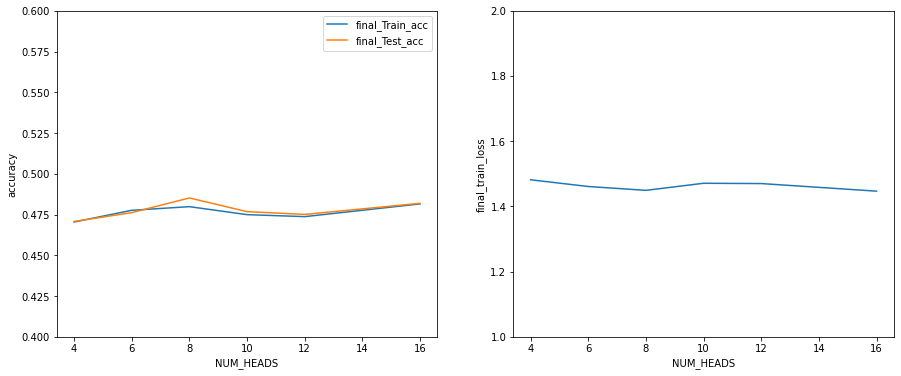

In [31]:
import numpy as np
X=np.array(list(num_head_map3.values())).T
plt.plot

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(DIFF_NUM_HEADS,X[1],label="final_Train_acc")
plt.plot(DIFF_NUM_HEADS,X[2],label="final_Test_acc")
plt.xlabel("NUM_HEADS")
plt.ylabel("accuracy")
plt.ylim(0.4, 0.6)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(DIFF_NUM_HEADS,X[0])
plt.xlabel("NUM_HEADS")
plt.ylabel("final_train_loss")
plt.ylim(1,2)
plt.plot()

#EXPERIMENT ON PATCH SIZE (EXPERIMENT 3)

In [33]:
DIFF_PATCH_SIZE=[2,4,8,16]
patch_size_map={}

In [34]:
 for PATCH_SIZE in DIFF_PATCH_SIZE:
  vit=ViT()
  loss_curve,train_acc_curve,test_acc_curve=train(model=vit,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      device=device,
      max_epochs=5,
      )
  patch_size_map[PATCH_SIZE]=[loss_curve[-1],train_acc_curve[-1],test_acc_curve[-1]]

PATCH_SIZE: 2 


 20%|██        | 1/5 [00:41<02:46, 41.58s/it]

epoch:1 train_loss:2.006661818742752 train_acc:0.2568799999999997 test_acc:0.35449999999999987


 40%|████      | 2/5 [01:22<02:02, 40.99s/it]

epoch:2 train_loss:1.7479529383182526 train_acc:0.36853999999999987 test_acc:0.39429999999999993


 60%|██████    | 3/5 [02:03<01:22, 41.06s/it]

epoch:3 train_loss:1.623609565258026 train_acc:0.41657999999999984 test_acc:0.4246999999999999


 80%|████████  | 4/5 [02:43<00:40, 40.87s/it]

epoch:4 train_loss:1.5377438766956328 train_acc:0.44617999999999935 test_acc:0.45779999999999993


100%|██████████| 5/5 [03:23<00:00, 40.79s/it]


epoch:5 train_loss:1.475751181125641 train_acc:0.4691799999999999 test_acc:0.4764
PATCH_SIZE: 4 


 20%|██        | 1/5 [00:40<02:42, 40.67s/it]

epoch:1 train_loss:1.9969986038208007 train_acc:0.26210000000000017 test_acc:0.3615


 40%|████      | 2/5 [01:20<02:01, 40.35s/it]

epoch:2 train_loss:1.7259259040355683 train_acc:0.37905999999999995 test_acc:0.40370000000000006


 60%|██████    | 3/5 [02:00<01:20, 40.27s/it]

epoch:3 train_loss:1.5991475536823272 train_acc:0.4276599999999996 test_acc:0.44339999999999996


 80%|████████  | 4/5 [02:41<00:40, 40.37s/it]

epoch:4 train_loss:1.51942369556427 train_acc:0.45654000000000006 test_acc:0.4671


100%|██████████| 5/5 [03:21<00:00, 40.31s/it]


epoch:5 train_loss:1.4551269967556 train_acc:0.47888000000000003 test_acc:0.4833000000000001
PATCH_SIZE: 8 


 20%|██        | 1/5 [00:40<02:40, 40.15s/it]

epoch:1 train_loss:2.014472932815552 train_acc:0.25469999999999987 test_acc:0.34749999999999986


 40%|████      | 2/5 [01:20<02:01, 40.36s/it]

epoch:2 train_loss:1.7517249331474305 train_acc:0.37147999999999964 test_acc:0.40610000000000007


 60%|██████    | 3/5 [02:00<01:20, 40.25s/it]

epoch:3 train_loss:1.6245324125289917 train_acc:0.41739999999999944 test_acc:0.44150000000000006


 80%|████████  | 4/5 [02:40<00:40, 40.23s/it]

epoch:4 train_loss:1.5372632176876069 train_acc:0.44939999999999924 test_acc:0.4635999999999998


100%|██████████| 5/5 [03:21<00:00, 40.26s/it]


epoch:5 train_loss:1.4733426773548126 train_acc:0.47198000000000007 test_acc:0.47539999999999993
PATCH_SIZE: 16 


 20%|██        | 1/5 [00:40<02:40, 40.11s/it]

epoch:1 train_loss:2.0088737349510195 train_acc:0.2577600000000002 test_acc:0.34800000000000003


 40%|████      | 2/5 [01:20<02:00, 40.09s/it]

epoch:2 train_loss:1.746525443315506 train_acc:0.36888 test_acc:0.3979


 60%|██████    | 3/5 [02:00<01:20, 40.17s/it]

epoch:3 train_loss:1.619400542974472 train_acc:0.4188799999999993 test_acc:0.4344999999999999


 80%|████████  | 4/5 [02:40<00:40, 40.15s/it]

epoch:4 train_loss:1.5300845103263856 train_acc:0.45121999999999934 test_acc:0.4635000000000001


100%|██████████| 5/5 [03:20<00:00, 40.12s/it]

epoch:5 train_loss:1.465781412601471 train_acc:0.4734799999999998 test_acc:0.4802


In [35]:
patch_size_map2=patch_size_map.copy()

[]

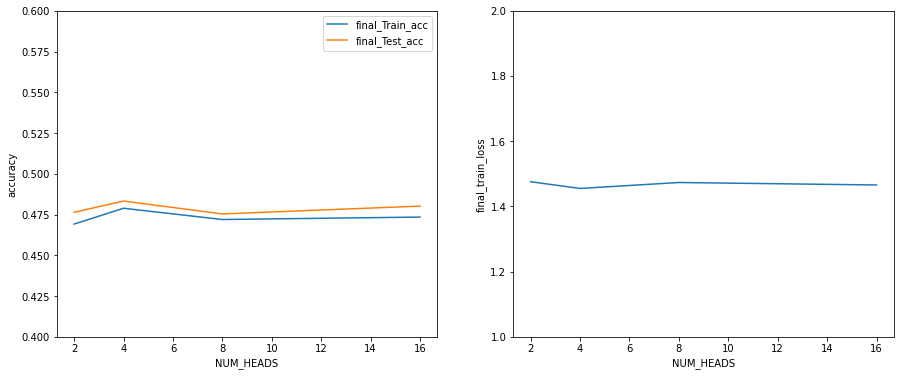

In [36]:
import numpy as np
X=np.array(list(patch_size_map2.values())).T
plt.plot

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(DIFF_PATCH_SIZE,X[1],label="final_Train_acc")
plt.plot(DIFF_PATCH_SIZE,X[2],label="final_Test_acc")
plt.xlabel("NUM_HEADS")
plt.ylabel("accuracy")
plt.ylim(0.4, 0.6)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(DIFF_PATCH_SIZE,X[0])
plt.xlabel("NUM_HEADS")
plt.ylabel("final_train_loss")
plt.ylim(1,2)
plt.plot()

#PREDICTION on custom image (JUST FOR CHECKING)

In [ ]:
img_tensor=next(iter(train_dataloader))[0][25]
print(img_tensor.shape)

plt.imshow(img_tensor.permute(1,2,0))

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
image = Image.open('horse.png')
image

In [ ]:
transform = transforms.Compose([
    
    transforms.PILToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE))
])
  
img_tensor = transform(image)
print(img_tensor.shape)

plt.imshow(img_tensor.permute(1,2,0))

In [ ]:
def predict(model=vit,img_tensor=img_tensor):
  X=img_tensor.unsqueeze(0)
  X=X.to(torch.float32)
  X=X.to(device)
  print(X.shape)
  y=model(X)
  print(y)
  print(train_dataset.classes[torch.argmax(y)])

In [ ]:
BATCH_SIZE=1
predict(img_tensor=img_tensor)

In [ ]:
print(train_dataset.classes)

#ViT (At every level)

100%|██████████| 10/10 [06:32<00:00, 39.26s/it]

done


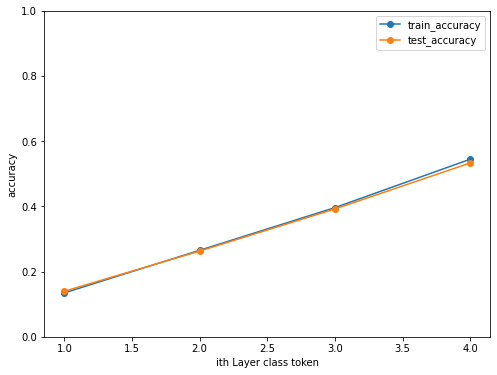

In [37]:
from tqdm import tqdm

#Hyper parameter
LEARNING_RATE=10**(-4)
BATCH_SIZE = 100 
IMG_SIZE = 32
PATCH_SIZE=4
IN_CHANNELS=3
EMBEDDING_DIMENTION=PATCH_SIZE*PATCH_SIZE*IN_CHANNELS*5
NUM_HEADS=8
NUM_ATTENTION_LAYERS=4
DROPOUT_P=0.1
MLP_SIZE=1024
NUM_LABELS=10

class ViT(nn.Module):
    
    def __init__(self,
                 img_size=IMG_SIZE, 
                 in_channels=IN_CHANNELS, 
                 patch_size=PATCH_SIZE, 
                 num_transformer_layers=NUM_ATTENTION_LAYERS, 
                 embedding_dim=EMBEDDING_DIMENTION, 
                 mlp_size=MLP_SIZE, 
                 num_heads=NUM_HEADS, 
                 attn_dropout=0, 
                 mlp_dropout=DROPOUT_P, 
                 embedding_dropout=DROPOUT_P, # Dropout for patch and position embeddings
                 num_classes=NUM_LABELS): 
        
        super().__init__() 
        
        
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
       
        self.patch_embedding = Patch_embedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        
        self.EncoderBlock1 = EncoderBlock(embedding_dim=embedding_dim,
                                        num_heads=num_heads,
                                        mlp_size=mlp_size,
                                        mlp_dropout=mlp_dropout)
        self.EncoderBlock2 = EncoderBlock(embedding_dim=embedding_dim,
                                        num_heads=num_heads,
                                        mlp_size=mlp_size,
                                        mlp_dropout=mlp_dropout)
        self.EncoderBlock3 = EncoderBlock(embedding_dim=embedding_dim,
                                        num_heads=num_heads,
                                        mlp_size=mlp_size,
                                        mlp_dropout=mlp_dropout)
        self.EncoderBlock4 = EncoderBlock(embedding_dim=embedding_dim,
                                        num_heads=num_heads,
                                        mlp_size=mlp_size,
                                        mlp_dropout=mlp_dropout)
       
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
        
    
    def forward(self, x):
        T=torch.zeros(4,BATCH_SIZE,NUM_LABELS)
        batch_size = BATCH_SIZE
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) 
        
        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.EncoderBlock1(x)
        T[0]=self.classifier(x[:, 0])
        x = self.EncoderBlock2(x)
        T[1]=self.classifier(x[:, 0])
        x = self.EncoderBlock3(x)
        T[2]=self.classifier(x[:, 0])
        x = self.EncoderBlock4(x)
        T[3]=self.classifier(x[:, 0])
        #print(T)
        #print("hello")
        return(T)  


def train(model,
          train_dataloader,
          test_dataloader,
          max_epochs,
          device,
         ):
    
    
    optimiser=torch.optim.Adam(params=model.parameters(), 
                             lr=10**(-4))
#                              betas=(0.9, 0.999), 
#                              weight_decay=0.3) 
    loss_fn=nn.CrossEntropyLoss()
    
    
    model.to(device)
    
    
    train_accuracy={0:0,1:0,2:0,3:0}
    test_accuracy={0:0,1:0,2:0,3:0}
    for epoch in tqdm(range(max_epochs)):
        model.train()
        train_accuracy={0:0,1:0,2:0,3:0}
        test_accuracy={0:0,1:0,2:0,3:0}
        
        for batch_id,(X,y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred=model(X)
            y_pred=y_pred.to(device)
            #print(y_pred.shape,y.shape,y_pred.device,y.device)

            loss={}
            loss[0]=loss_fn(y_pred[0],y)
            loss[1]=loss_fn(y_pred[1],y)
            loss[2]=loss_fn(y_pred[2],y)
            loss[3]=loss_fn(y_pred[3],y)
            
            
            
            
            optimiser.zero_grad()
            loss[3].backward()
            optimiser.step()
            
            
            
            
            
            batch_correct={}
            batch_correct[0]=((torch.argmax(y_pred[0],dim=1)==y).sum().item())/BATCH_SIZE
            batch_correct[1]=((torch.argmax(y_pred[1],dim=1)==y).sum().item())/BATCH_SIZE
            batch_correct[2]=((torch.argmax(y_pred[2],dim=1)==y).sum().item())/BATCH_SIZE
            batch_correct[3]=((torch.argmax(y_pred[3],dim=1)==y).sum().item())/BATCH_SIZE

            train_accuracy[0]+=batch_correct[0]
            train_accuracy[1]+=batch_correct[1]
            train_accuracy[2]+=batch_correct[2]
            train_accuracy[3]+=batch_correct[3]
           # print(loss.item(),batch_correct)
        


        for batch_id,(X,y) in enumerate(test_dataloader):
                  
            X, y = X.to(device), y.to(device)
            y_pred=model(X)
            y_pred=y_pred.to(device)
            
          
            batch_correct={}
            batch_correct[0]=((torch.argmax(y_pred[0],dim=1)==y).sum().item())/BATCH_SIZE
            batch_correct[1]=((torch.argmax(y_pred[1],dim=1)==y).sum().item())/BATCH_SIZE
            batch_correct[2]=((torch.argmax(y_pred[2],dim=1)==y).sum().item())/BATCH_SIZE
            batch_correct[3]=((torch.argmax(y_pred[3],dim=1)==y).sum().item())/BATCH_SIZE

            test_accuracy[0]+=batch_correct[0]
            test_accuracy[1]+=batch_correct[1]
            test_accuracy[2]+=batch_correct[2]
            test_accuracy[3]+=batch_correct[3]
            
              
              
    
    
    print("done")
    return train_accuracy,test_accuracy

vit=ViT()
train_accuracy,test_accuracy=train(model=vit,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      device=device,
      max_epochs=10,
      )


import numpy as np
a=np.array(list(train_accuracy.values()))/len(train_dataloader)
b=np.array(list(test_accuracy.values()))/len(test_dataloader)
a,b
plt.figure(figsize=(8,6))
plt.plot([1,2,3,4],a,marker='o',label="train_accuracy")
plt.plot([1,2,3,4],b,marker='o',label="test_accuracy")
plt.xlabel("ith Layer class token")
plt.ylabel("accuracy")
plt.legend()
plt.ylim(0,1)
plt.show()

        
            
        